In [4]:
# Tensorflow / Keras

from tensorflow import keras # for building neural networks
from keras.models import Sequential # for assembling a neural network
from keras.layers import Dense # adding layers to the neural network
from tensorflow.keras.utils import plot_model # for ploting model digram


# Data manipulation

import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import math # for generating read date (points on a circle)


# Visualization

import matplotlib
import matplotlib.pyplot as plt # for date visualization
import graphviz #for showing model digram
import plotly
import plotly.express as px # for date visualization


# Other utilities

import sys
import os

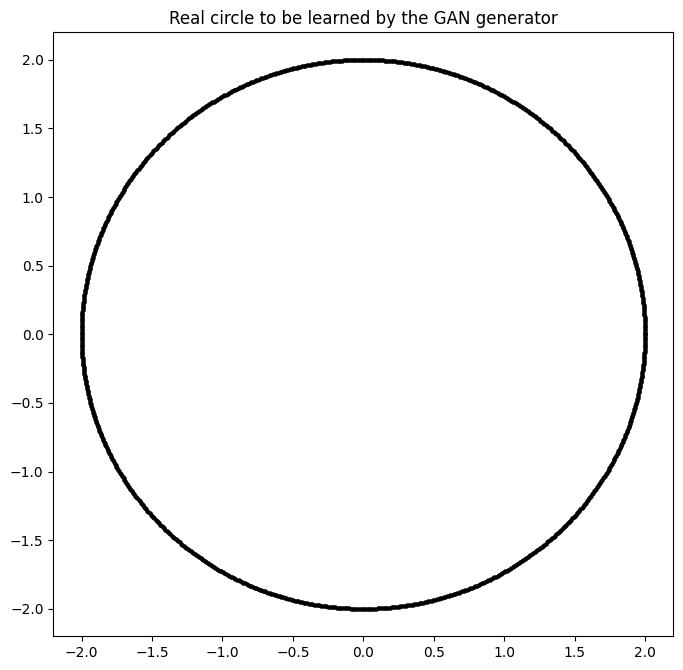

In [10]:
# A function to get coordinates of points on circle's circumference

def PointInCircum(r , n = 100):
    return [(math.cos(2*math.pi/n*x)*r,math.sin(2*math.pi/n*x)*r) for x in range(0,n+1)]


# Save coordinates of a set of real points making up a circle with radius = 2

circle = np.array(PointInCircum(r = 2 , n = 1000))


# Draw a chart

plt.figure(figsize = (8,8)  , dpi = 100)

plt.title(label = 'Real circle to be learned by the GAN generator' , loc = 'center')

plt.scatter(circle[: , 0] ,circle[: , 1] , s =5 , color = 'black')

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator-Hidden-Layer-1 (D  (None, 32)               128       
 ense)                                                           
                                                                 
 Generator-Hidden-Layer-2 (D  (None, 16)               528       
 ense)                                                           
                                                                 
 Generator-Output-Layer (Den  (None, 2)                34        
 se)                                                             
                                                                 
Total params: 690
Trainable params: 690
Non-trainable params: 0
_________________________________________________________________


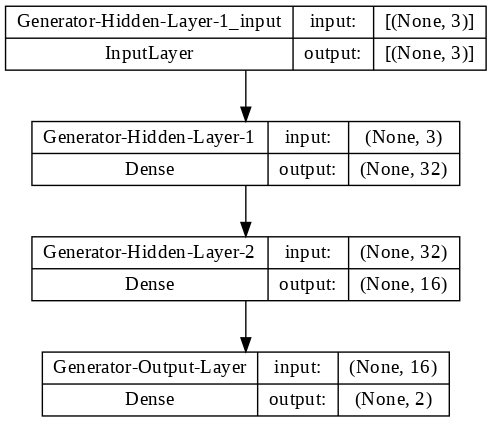

In [11]:
# Define Generator model

def generator(latent_dim , n_outputs = 2):
  model = Sequential(name = 'Generator')    # Model

  # Add layers

  model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim= latent_dim, name='Generator-Hidden-Layer-1')) # Hidden Layer
  model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Generator-Hidden-Layer-2')) # Hidden Layer    
  model.add(Dense(n_outputs, activation='linear', name='Generator-Output-Layer')) # Output Layer
  return model


# Instantiate

latent_dim = 3
gen_model = generator(latent_dim)

# Show model summary and plot model diagram

gen_model.summary()
plot_model(gen_model , show_shapes= True , show_layer_names = True , dpi = 100)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Discriminator-Hidden-Layer-  (None, 32)               96        
 1 (Dense)                                                       
                                                                 
 Discriminator-Hidden-Layer-  (None, 16)               528       
 2 (Dense)                                                       
                                                                 
 Discriminator-Output-Layer   (None, 1)                17        
 (Dense)                                                         
                                                                 
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


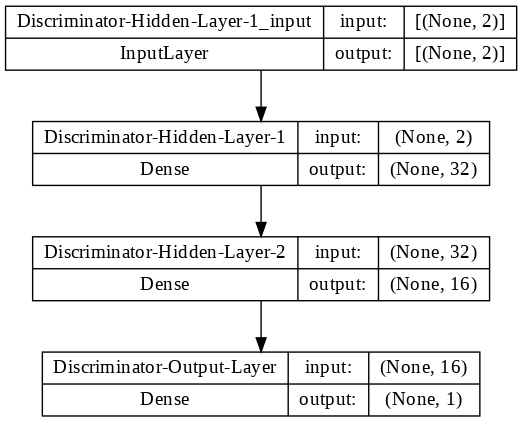

In [12]:
# Define a Discriminator model

def discriminator(n_inputs =2):

  model = Sequential(name = 'Discriminator')


  # Add layers

  model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs, name='Discriminator-Hidden-Layer-1')) # Hidden Layer
  model.add(Dense(16, activation='relu', kernel_initializer='he_uniform', name='Discriminator-Hidden-Layer-2')) # Hidden Layer
  model.add(Dense(1, activation='sigmoid', name='Discriminator-Output-Layer')) # Output Layer

  # Compile the model

  model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

  return model
    
# Instantiate

dis_model = discriminator()

# show model summary and plot model diagram

dis_model.summary()
plot_model(dis_model , show_shapes = True , show_layer_names = True , dpi = 100)

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generator (Sequential)      (None, 2)                 690       
                                                                 
 Discriminator (Sequential)  (None, 1)                 641       
                                                                 
Total params: 1,331
Trainable params: 690
Non-trainable params: 641
_________________________________________________________________


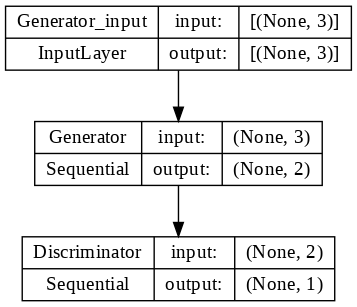

In [18]:
# Define the main model

def def_gan(generator , discriminator):
  discriminator.trainable = False

  # Combine

  model = Sequential(name = 'GAN')
  model.add(generator)
  model.add(discriminator)

  # compile the model

  model.compile(loss = 'binary_crossentropy' , optimizer = 'adam')
  return model

# Instantiate

gan_model = def_gan(gen_model , dis_model)

# show model summary and plot model diagram

gan_model.summary()
plot_model(gan_model , show_shapes = True , show_layer_names= True , dpi = 100)

In [33]:
# Set up a function = sample random points from our circle

def real_samples(n):

  # samples of real date
  X = circle[np.random.choice(circle.shape[0] , n , replace = True) , :]

  # Class labels

  y = np.ones((n , 1))
  return X ,y


# Generate points in the latent space , which we I will use as inputs for the generator

def latent_points(latent_dim , n):

  # Generate points in the latent space
  latent_input = np.random.randn(latent_dim * n)

  # Reshape into a batch of inputs for the network
  latent_input = latent_input.reshape(n , latent_dim)

  return latent_input



# Use the generator to generate n fake examples together with class labels

def fake_samples(generator , latent_dim , n):

  # Generate points in latent space
  latent_output = latent_points(latent_dim , n)

  # predict outputs (i.e., gererate fake samples)

  X = generator.predict(latent_output)

  # Create class labels

  y = np.zeros((n , 1))
  return X , y

In [40]:
def performance_summray(epoch, generator , discriminator , latent_dim , n =100):

  # Get samples of the real date

  x_real , y_real = real_samples(n)

  # Evaluate the disciminator on real date

  _ , real_accuracy = discriminator.evaluate(x_real , y_real)


  # Get fake (generated) samples

  x_fake , y_fake = fake_samples(generator, latent_dim , n)

  # Evaluate the disciminator on fake (generated) date

  _ , fake_accuracy = discriminator.evaluate(x_fake , y_fake , verbose = 1)

  # summarize discriminator performance

  print('Epoch number ' , epoch)
  print('Discriminator Accuracy on REAL points: ' , real_accuracy)
  print('Discriminator Accuracy on FAKE (generated) points: ' , fake_accuracy)

  # Creat a 2D scatter plot to show real and fake (generated) data points

  plt.figure(figsize  = (4,4) , dpi = 100)
  plt.scatter(x_real[:,0] , x_real[:,1] , s = 5 , color = 'blue')
  plt.scatter(x_fake[:,0] , x_fake[: , 1] , s=5 , color = 'red')
  plt.show()

In [41]:
# The training function

def train(g_model ,d_model, gan_model , latent_dim , n_epochs = 10001 , n_batch = 256 , n_eval = 1000 ):

  half_batch = int(n_batch / 2)
  # I will manually enumare epochs

  for i in range(n_epochs):

  # Discriminator training
    
    # prep real samples
    x_real , y_real = real_samples(half_batch)
    # prep fake smaples
    x_fake , y_fake = fake_samples(g_model ,latent_dim , half_batch)

    # train the discriminator using real and fake samples
    d_model.train_on_batch(x_real , y_real)
    d_model.train_on_batch(x_fake , y_fake)

  # Generator training
    # get points from the latent space to be used as inputs for the generator
    x_gan = latent_points(latent_dim , n_batch)
    y_gan = np.ones((n_batch , 1))

    gan_model.train_on_batch(x_gan,y_gan)

    # Evaluate the model at every n_evel epochs

    if(i) % n_eval == 0:
      performance_summray(i , g_model , d_model , latent_dim)

In [ ]:
# Train GAN model
train(gen_model , dis_model , gan_model , latent_dim)